In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

In [2]:
! pip install gym --upgrade

In [3]:
NUM_RUNS = 20
EPSILON = 0.3    # placeholder value - you should implement your own exploration schedule

In [4]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([4,128,125,2])
    target_net = DQN([4, 128,125,2])
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.SGD(policy_net.parameters(), lr=1e-3)
    memory = ReplayBuffer(100000)

    steps_done = 0

    episode_durations = []

    for i_episode in range(300):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 300)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < 200:
                transitions = memory.sample(200)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()

            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % 1 == 0:
            update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')
# Calculate average rewards over the last 50 episodes for each run
average_rewards = [np.mean(run[-50:]) for run in runs_results]

# Check if average reward over 10 runs for the last 50 episodes is >= 100
if np.mean(average_rewards) >= 100:
    print("Average reward over 10 runs for the last 50 episodes reached >= 100")
else:
    print("The average reward over 10 runs for the last 50 episodes did not reach 100")

Starting run 1 of 20
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 20
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 20
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 20
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 20
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 20
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 20
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 20
episode  50 / 300
episode  100 / 300
epis

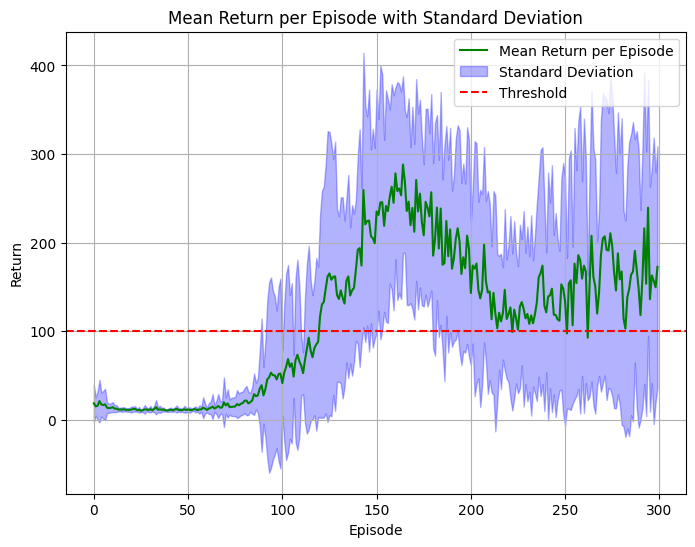

In [5]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

# Plotting the mean return per episode with standard deviation
plt.figure(figsize=(8, 6))
plt.plot(torch.arange(means.shape[0]), means, color='g', label='Mean Return per Episode')
plt.fill_between(torch.arange(means.shape[0]), means + stds, means - stds, color='b', alpha=0.3, label='Standard Deviation')
#plt.plot(torch.arange(means.shape[0]), results.T, color='grey', alpha=0.3)  # Plotting individual run returns in grey

# Drawing a dotted line at y = 100
plt.axhline(y=100, color='red', linestyle='--', label='Threshold')

plt.ylabel("Return")
plt.xlabel("Episode")
plt.title("Mean Return per Episode with Standard Deviation")
plt.legend()
plt.grid(True)
plt.show()

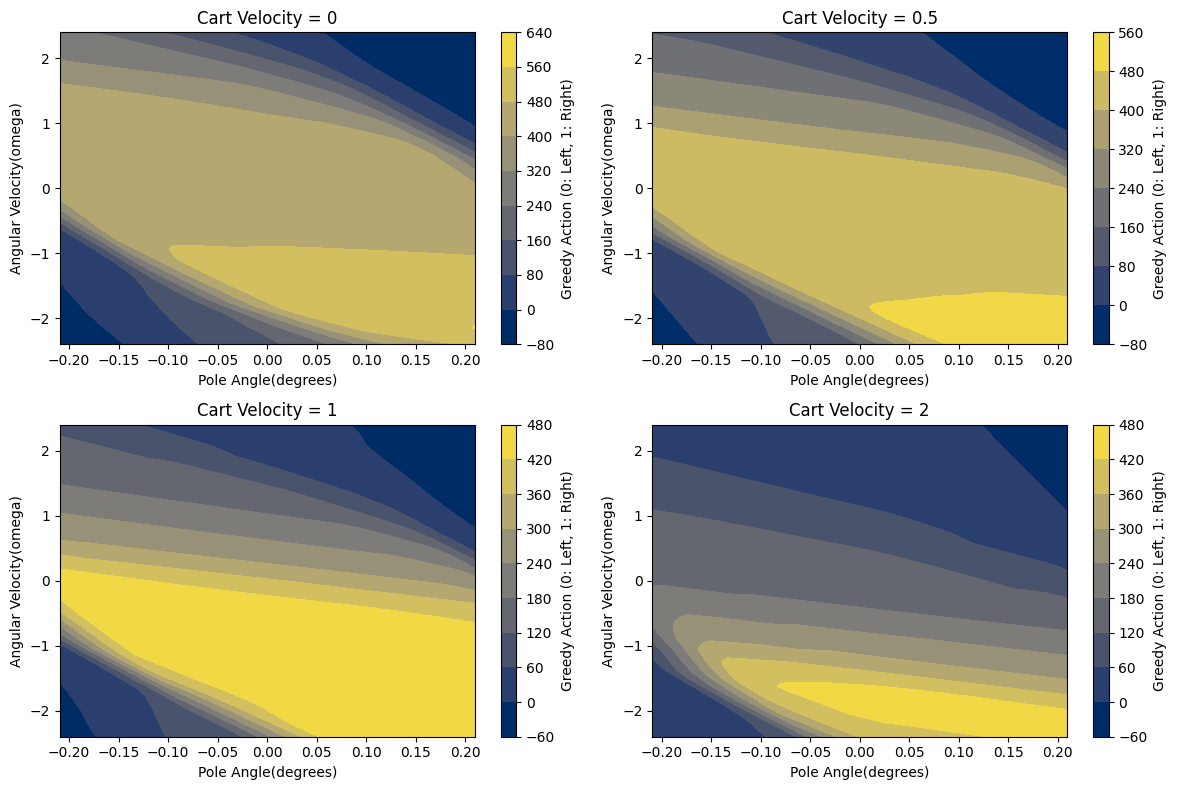

In [8]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

# Define the ranges and samples for pole angle and angular velocity
angle_range = 0.2094  # ±12 degrees in radians
omega_range = 2.4  # Cart velocities

angle_samples = 100
omega_samples = 100
angles = torch.linspace(-angle_range, angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

# Function to filter states based on specified conditions
def filter_states(angle, omega):
    return (abs(angle) > 0.2094 or abs(omega) > 2.4)

# Plotting greedy Q-values for different cart velocities
cart_velocities = [0, 0.5, 1, 2]
plt.figure(figsize=(12, 8))

for idx, velocity in enumerate(cart_velocities, 1):
    greedy_q_array = torch.zeros((angle_samples, omega_samples))

    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_q_array[i, j] = q_vals.max()

    plt.subplot(2, 2, idx)
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis')
    plt.xlabel('Pole Angle(degrees)')
    plt.ylabel('Angular Velocity(omega)')
    plt.title(f'Cart Velocity = {velocity}')
    plt.colorbar(label='Greedy Action (0: Left, 1: Right)')

plt.tight_layout()
plt.show()

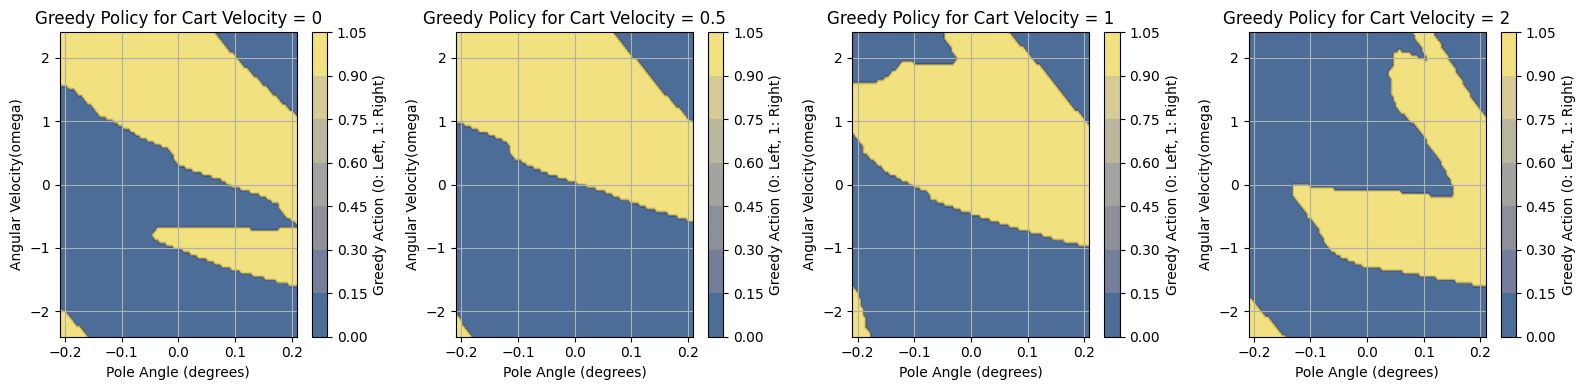

In [9]:
# Define the ranges and samples for pole angle and angular velocity
angle_range = 0.2094  # ±12 degrees in radians
omega_range = 2.4  # ±2.4 cart velocity range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(-angle_range, angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

# Function to visualize the greedy policy for a specific cart velocity
def visualize_greedy_policy(cart_velocity, ax):
    greedy_q_array = torch.zeros((angle_samples, omega_samples))

    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., cart_velocity, angle, omega])
            if abs(angle) > angle_range or abs(omega) > omega_range:
                # Mark excluded states with a specific value for clear coloring
                greedy_q_array[i, j] = -1
            else:
                with torch.no_grad():
                    q_vals = policy_net(state)
                    greedy_action = q_vals.argmax()
                    greedy_q_array[i, j] = greedy_action

    # Mask out the excluded states (-1) for proper coloring
    masked_data = np.ma.masked_where(greedy_q_array == -1, greedy_q_array)

    c = ax.contourf(angles, omegas, masked_data.T, cmap='cividis', alpha=0.7)
    ax.set_xlabel('Pole Angle (degrees)')
    ax.set_ylabel('Angular Velocity(omega)')
    ax.set_title(f'Greedy Policy for Cart Velocity = {cart_velocity}')
    plt.colorbar(c, ax=ax, label='Greedy Action (0: Left, 1: Right)')
    ax.grid(visible=True)

# Set up subplots for displaying the greedy policies
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Visualize the greedy policy for different cart velocities
cart_velocities = [0, 0.5, 1, 2]
for i, velocity in enumerate(cart_velocities):
    visualize_greedy_policy(velocity, axs[i])

plt.tight_layout()
plt.show()